# 08 — Quant Strategies & Backtesting Framework (Classical Signals)

This notebook builds the signal-generation and backtesting layer of the quantitative pipeline.  
Using the clean return and price series produced in Notebook 01, and the risk-and-volatility diagnostics obtained in Notebooks 03–05, it implements a set of classical, interpretable trading rules widely used in academic research and discretionary quantitative strategies.  
It serves as the bridge between statistical market characterisation and rule-based trading, providing a transparent framework to test signals such as momentum, mean-reversion, moving-average systems, and volatility filters.  
The notebook emphasises simplicity, interpretability, and methodological clarity — deliberately avoiding machine learning, forecasting models, and advanced risk frameworks so as not to overlap with the TFM.

### Objectives
- Construct momentum and reversal indicators using rolling return windows.  
- Implement moving-average systems (SMA/EMA) and crossover rules for trend detection.  
- Apply volatility filters to modulate exposure during high-risk regimes.  
- Build a lightweight vectorised backtesting engine for long/flat and long/short strategies.  
- Evaluate performance through cumulative returns, drawdowns, hit ratios, turnover and Sharpe ratio.  
- Compare signals and assess robustness across assets and parameter choices.  
- Export signal histories and strategy returns for Power BI dashboards and later analysis.

### Inputs
| File | Description |
|------|-------------|
| `/data/processed/clean_prices.csv` | Price series required to compute indicators. |
| `/data/processed/log_returns.csv` | Returns used for backtesting. |
| `/data/powerbi/volatility_panel.csv` (optional) | Volatility series to create volatility-based filters. |

### Outputs
| File | Description |
|------|-------------|
| `/figures/08.Strategies/momentum_signal.png` | Momentum signal vs prices. |
| `/figures/08.Strategies/ma_crossover.png` | Moving-average crossover signals. |
| `/figures/08.Strategies/strategy_equity_curves.png` | Equity curves for all strategies. |
| `/figures/08.Strategies/drawdown_comparison.png` | Drawdown profiles across strategies. |
| `/data/powerbi/strategies_panel.csv` | Signals, positions and strategy returns. |

### Strategies Implemented
| Strategy | Purpose |
|----------|---------|
| **Momentum (12–1, 6–1, configurable)** | Capture trend persistence using past returns. |
| **Mean-Reversion / Short-Term Reversal** | Exploit short-horizon price overreaction. |
| **Moving-Average Systems (SMA/EMA)** | Smooth trend-following signals. |
| **MA Crossovers (Golden/Death Cross)** | Regime identification via trend-confirmation rules. |
| **Volatility Filters** | Reduce exposure during high-volatility periods. |

### Notebook Structure
1. **Load Prices & Returns**  
   Prepare datasets, construct forward-returns and validate data integrity.
2. **Momentum & Reversal Indicators**  
   Build standard academic momentum and mean-reversion signals.
3. **Moving Averages & Crossover Rules**  
   Implement SMA, EMA and long/flat (or long/short) crossover systems.
4. **Volatility Filters**  
   Use rolling volatility or Notebook-04 volatility to condition exposure.
5. **Backtesting Engine**  
   Compute positions, PnL, cumulative returns, turnover and risk metrics.
6. **Performance Comparison**  
   Compare Sharpe, drawdowns, win rates, and sensitivity to parameters.
7. **Export to Power BI**  
   Save signals, positions and equity curves for dashboards.
8. **Conclusions**  
   Discuss robustness, signal behaviour, and suitability for real allocation.

This notebook provides the strategy-testing engine of the project: a clean, interpretable platform to prototype classical quantitative signals and evaluate their behaviour under a consistent backtesting framework, without entering the domain of predictive machine learning or complex risk modelling.

## 1. Load Prices & Returns

This introductory section prepares the full multi-asset dataset that will feed all trading signals and backtests in this notebook. We load daily prices and log-returns from the project’s processed data layer, enforce strict alignment between both tables, and create forward-returns needed for evaluating next-day PnL.  

Before any modelling, the dataset is validated for missing values, duplicated timestamps, monotonicity of the index structure, and consistency of asset coverage across prices and returns.

### Data ingestion and alignment  
We import clean price levels and log-returns for the four main equity indices used throughout the forecasting pipeline (IBEX35, SP500, EUROSTOXX50, NASDAQ100). Any date mismatches between prices and returns are removed by intersecting indices, guaranteeing coherent input for signal generation.

Forward-returns are created via a simple one-day shift, representing the payoff realised after today’s signal decision. This is the core target series for all strategy PnL computations in later sections.

### Visual inspection  
Two diagnostic charts summarise the behaviour of the assets across 25 years:

- Price evolution: equity indices exhibit long-term growth (especially SP500 and NASDAQ100), while EUROSTOXX50 and IBEX35 show weaker compounding and stronger cyclicality. These structural differences matter for momentum-based signals and risk filters.
- Daily log returns: the return series clearly display volatility clustering and heavy-tailed shocks (e.g., dot-com crash, 2008 crisis, Covid-19). These patterns justify using volatility-conditioned exposure rules in Section 4.

Loaded price panel:


,IBEX35,SP500,EUROSTOXX50,NASDAQ100
Date,,,,
2000-01-03,11609.988281,1455.219971,4181.029785,3790.550049
2000-01-04,11206.587891,1399.420044,4181.029785,3546.199951
2000-01-05,10863.088867,1402.109985,4181.029785,3507.310059
2000-01-06,10863.088867,1403.449951,4181.029785,3340.810059
2000-01-07,11102.388672,1441.469971,4181.029785,3529.600098


Loaded return panel:


,IBEX35,SP500,EUROSTOXX50,NASDAQ100
Date,,,,
2000-01-04,-0.035364,-0.039099,0.0,-0.066635
2000-01-05,-0.031131,0.001920,0.0,-0.011027
2000-01-06,0.000000,0.000955,0.0,-0.048636
2000-01-07,0.021790,0.026730,0.0,0.054971
2000-01-10,0.006366,0.011128,0.0,0.051843


Aligned price panel:


,IBEX35,SP500,EUROSTOXX50,NASDAQ100
Date,,,,
2000-01-04,11206.587891,1399.420044,4181.029785,3546.199951
2000-01-05,10863.088867,1402.109985,4181.029785,3507.310059
2000-01-06,10863.088867,1403.449951,4181.029785,3340.810059
2000-01-07,11102.388672,1441.469971,4181.029785,3529.600098
2000-01-10,11173.288086,1457.599976,4181.029785,3717.409912


Aligned return panel:


,IBEX35,SP500,EUROSTOXX50,NASDAQ100
Date,,,,
2000-01-04,-0.035364,-0.039099,0.0,-0.066635
2000-01-05,-0.031131,0.001920,0.0,-0.011027
2000-01-06,0.000000,0.000955,0.0,-0.048636
2000-01-07,0.021790,0.026730,0.0,0.054971
2000-01-10,0.006366,0.011128,0.0,0.051843


Forward returns preview:


,IBEX35,SP500,EUROSTOXX50,NASDAQ100
Date,,,,
2000-01-04,-0.031131,0.001920,0.0,-0.011027
2000-01-05,0.000000,0.000955,0.0,-0.048636
2000-01-06,0.021790,0.026730,0.0,0.054971
2000-01-07,0.006366,0.011128,0.0,0.051843
2000-01-10,-0.014505,-0.013149,0.0,-0.047672


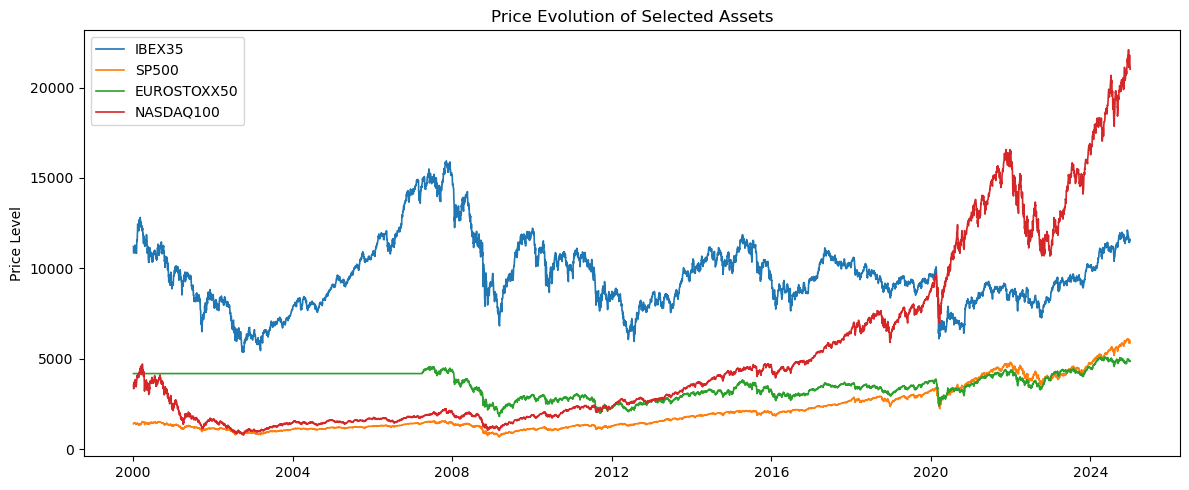

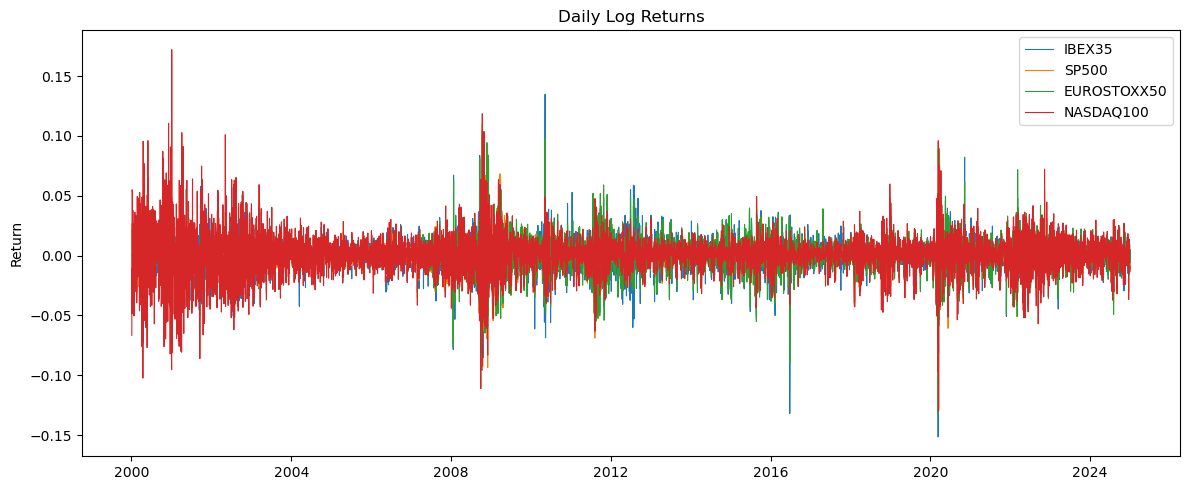

Section 1 completed: Data loaded, validated, visualised.


In [5]:
# 1. Load Prices & Returns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# 1.1 Directories (relative paths only)
DATA_PRO = Path("../data/processed")
FIG_DIR = Path("../../figures/08.Strategies")
FIG_DIR.mkdir(parents=True, exist_ok=True)

# 1.2 Load prices and returns
prices = pd.read_csv(DATA_PRO / "clean_prices.csv",
                     parse_dates=["Date"], index_col="Date")

returns = pd.read_csv(DATA_PRO / "log_returns.csv",
                      parse_dates=["Date"], index_col="Date")

# Focus on main equity assets (adjust as needed)
assets = ["IBEX35", "SP500", "EUROSTOXX50", "NASDAQ100"]
px = prices[assets].dropna()
ret = returns[assets].dropna()

print("Loaded price panel:")
display(px.head())

print("Loaded return panel:")
display(ret.head())

# 1.3 Basic checks & index alignment

# Align both datasets to the common intersection of dates
common_idx = px.index.intersection(ret.index)

px = px.loc[common_idx]
ret = ret.loc[common_idx]

# Forward return must also be trimmed later
print("Aligned price panel:")
display(px.head())

print("Aligned return panel:")
display(ret.head())

# New consistency checks
assert px.notna().all().all(), "Missing values in prices after alignment."
assert ret.notna().all().all(), "Missing values in returns after alignment."
assert px.index.is_monotonic_increasing, "Date index not sorted."
assert ret.index.is_monotonic_increasing, "Date index not sorted."

# 1.4 Compute forward returns for backtesting
# Forward 1-day return = next day's return (shift backwards)
fw_ret = ret.shift(-1)

print("Forward returns preview:")
display(fw_ret.head())

# 1.5 Visual inspection of price evolution
fig, ax = plt.subplots(figsize=(12, 5))

for a in assets:
    ax.plot(px.index, px[a], label=a, linewidth=1.2)

ax.set_title("Price Evolution of Selected Assets")
ax.set_ylabel("Price Level")
ax.legend()

plt.tight_layout()
plt.savefig(FIG_DIR / "price_evolution.png", dpi=200, bbox_inches="tight")
plt.show()

# 1.6 Visual inspection of returns
fig, ax = plt.subplots(figsize=(12, 5))

for a in assets:
    ax.plot(ret.index, ret[a], label=a, linewidth=0.8)

ax.set_title("Daily Log Returns")
ax.set_ylabel("Return")
ax.legend()

plt.tight_layout()
plt.savefig(FIG_DIR / "returns_evolution.png", dpi=200, bbox_inches="tight")
plt.show()

print("Section 1 completed: Data loaded, validated, visualised.")


## 2. Momentum & Reversal Indicators — Explanation

This section builds two core families of signals used in cross-asset and equity-index systematic trading: trend-following momentum and short-term mean reversion. Each indicator targets a fundamentally different market behaviour, and the code operationalises these concepts in a clean, research-standard way.

### 2.1 Momentum Metrics (Long- and Short-Horizon)

We compute price momentum using classical academic definitions:  
- 12-month momentum (252 trading days) captures medium-term trend persistence.  
- 1-month momentum (21 days) acts as a faster trend indicator.

The momentum measure is simply the percentage change between today’s price and the price k days ago. A binary long/flat rule,  
signal = 1 when momentum > 0,  
induces a slow-moving strategy that takes exposure only when the asset has been persistently appreciating.

In the SP500 example plot, the 12-month momentum series shows long waves of positive values during extended bull markets and deep prolonged negatives during crisis phases. This underscores the structural behaviour of momentum: it reacts slowly, avoids frequent trading, and aligns with macro-economic cycles, not daily noise.

### 2.2 Short-Term Reversal (5-Day Mean Reversion)

To capture micro-level overreaction and liquidity shocks, we compute a 5-day reversal signal based on the negative accumulated recent returns. This identifies assets that have fallen sharply in the short term.

The rolling sum of returns is then z-scored, allowing thresholding:  
signal = 1 when z-score < –1,  
meaning the asset has dropped far more than usual relative to its own historical behaviour.

As the plots show, reversal z-scores spike frequently and exhibit heavy tails, a hallmark of short-horizon risk. Signals fire often, confirming that reversal strategies inherently imply high turnover and are far more reactive than trend-followers.

### 2.3 Behavioural Interpretation

- **Momentum** captures *persistent market regimes*: it is slow, stable, and acts like a macro trend filter.  
- **Reversal** captures *temporary dislocations*: it is noisy, high-frequency, and sensitive to volatility bursts.

This difference is crucial for later sections. Momentum tends to perform during stable expansions but suffers during regime breaks. Reversal thrives in choppy or mean-reverting markets but collapses when trends dominate.

Understanding these dynamics is essential when combining the strategies, evaluating their Sharpe ratios, and analysing robustness during backtesting. These patterns explain why professional multi-asset strategies often integrate both slow (trend) and fast (reversal) signals to diversify behaviour across regimes.

Section 2 establishes this foundation visually and quantitatively before moving into filtering, execution and performance measurement.


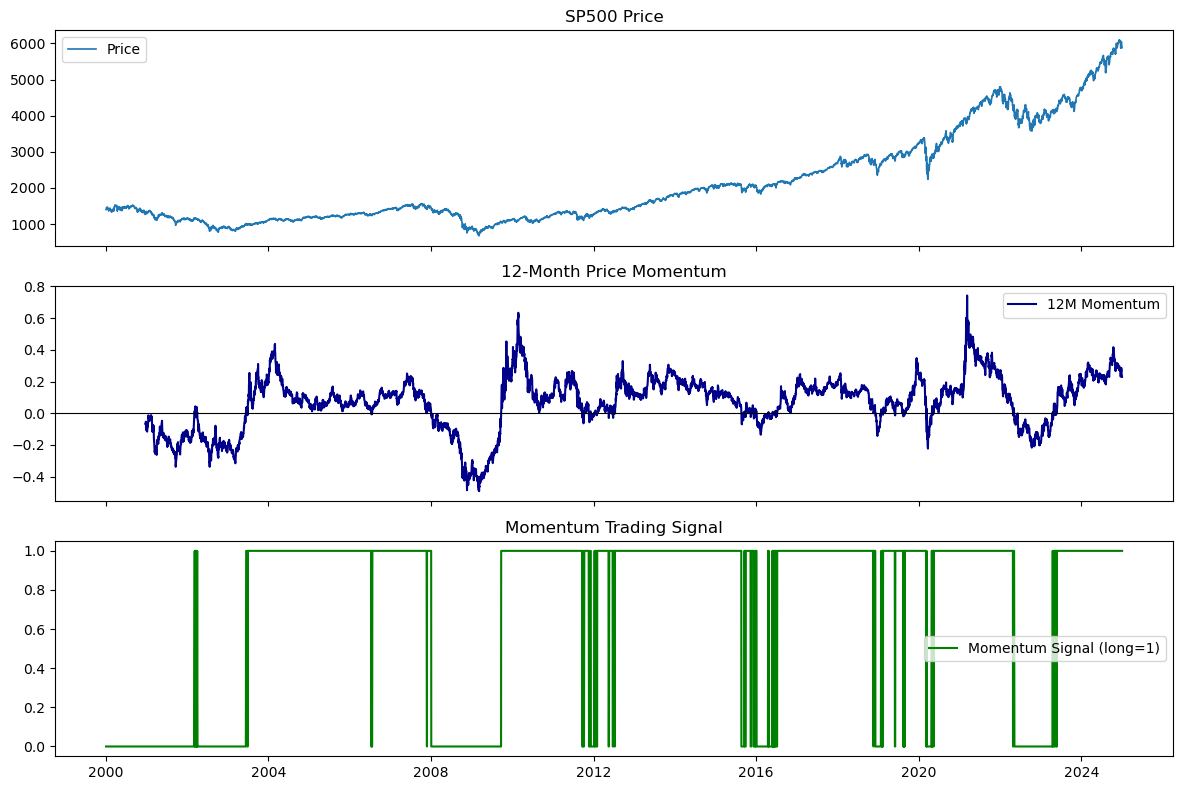

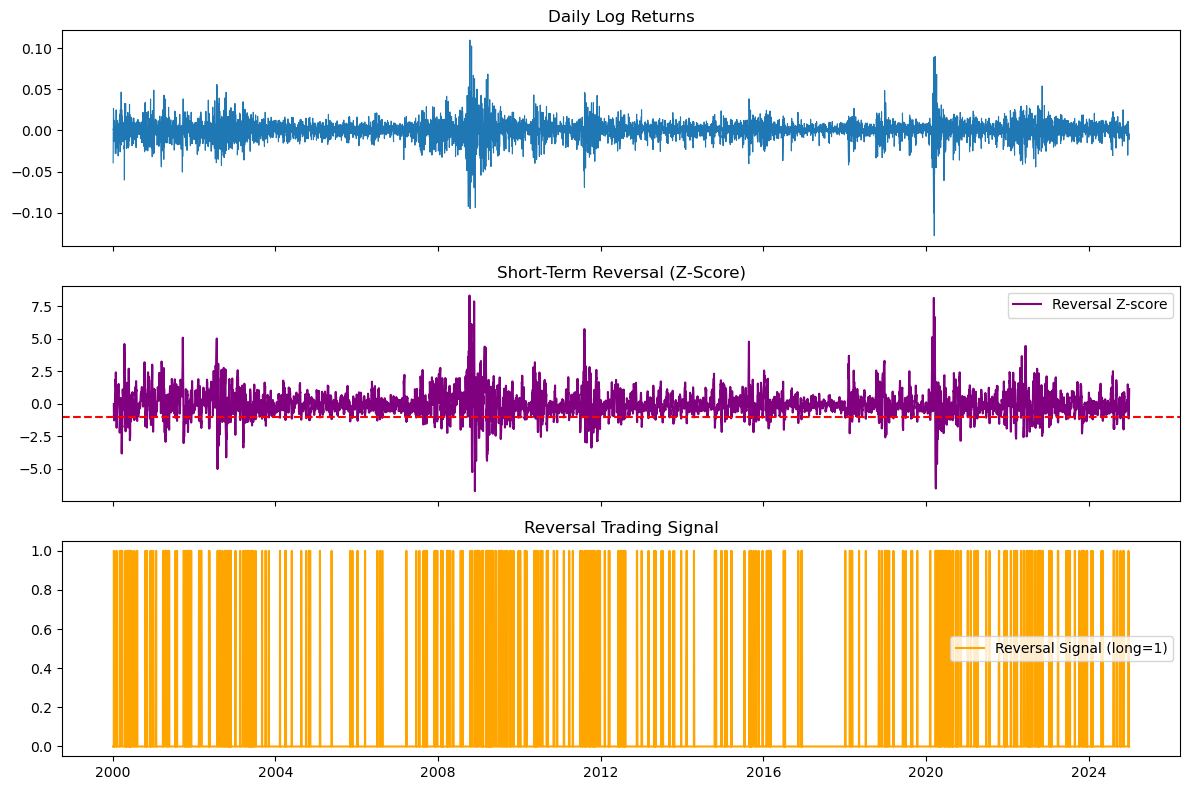

Section 2 completed: Momentum and Reversal signals computed.


In [7]:
# 2. Momentum & Reversal Indicators

# 2.1 Parameters
# Classical research defaults:
MOM_LONG = 252    # 12-month momentum
MOM_SHORT = 21    # 1-month momentum
REV_WINDOW = 5    # 5-day short-term reversal

# 2.2 Momentum: (Price_t / Price_{t-k}) - 1
mom_long = px.pct_change(MOM_LONG)     # 12m momentum
mom_short = px.pct_change(MOM_SHORT)   # 1m momentum

# Binary long/flat signal
signal_mom = (mom_long > 0).astype(int)

# 2.3 Short-term Reversal: negative of recent returns

rev_signal = -ret.rolling(REV_WINDOW).sum()

# Standardised version (z-score)
rev_z = (rev_signal - rev_signal.mean()) / rev_signal.std()

# Long if extreme negative short-term return (mean reversion)
signal_rev = (rev_z < -1).astype(int)

# 2.4 Plot signals for one example asset
asset = "SP500"

fig, ax = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

ax[0].plot(px[asset], label="Price", linewidth=1.2)
ax[0].set_title(f"{asset} Price")
ax[0].legend()

ax[1].plot(mom_long[asset], label="12M Momentum", color="darkblue")
ax[1].axhline(0, color="black", linewidth=0.8)
ax[1].set_title("12-Month Price Momentum")
ax[1].legend()

ax[2].plot(signal_mom[asset], label="Momentum Signal (long=1)", color="green")
ax[2].set_title("Momentum Trading Signal")
ax[2].legend()

plt.tight_layout()
plt.savefig(FIG_DIR / "momentum_signal.png", dpi=200, bbox_inches="tight")
plt.show()

# Reversal figure
fig, ax = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

ax[0].plot(ret[asset], linewidth=0.8)
ax[0].set_title("Daily Log Returns")

ax[1].plot(rev_z[asset], label="Reversal Z-score", color="purple")
ax[1].axhline(-1, linestyle="--", color="red")
ax[1].set_title("Short-Term Reversal (Z-Score)")
ax[1].legend()

ax[2].plot(signal_rev[asset], label="Reversal Signal (long=1)", color="orange")
ax[2].set_title("Reversal Trading Signal")
ax[2].legend()

plt.tight_layout()
plt.savefig(FIG_DIR / "reversal_signal.png", dpi=200, bbox_inches="tight")
plt.show()

print("Section 2 completed: Momentum and Reversal signals computed.")


## Section 3 — Analytical Summary: Moving Averages & Crossover Rules

This section formalises two of the most widely used rule-based trend-following systems in quantitative finance:  
SMA crossovers (slow, structurally stable) and EMA crossovers (fast, reactive).  
Although simple in construction, these techniques encapsulate core principles of market microstructure, behavioural dynamics and signal extraction under noise.

### 1. What the indicators measure  
- **SMA(50/200):** provides a slow-moving structural trend estimate. Because it treats all past observations equally, it smooths short-term noise and reacts mainly to regime-scale movements.  
- **EMA(20/50):** assigns exponentially heavier weight to recent data, making the signal more responsive to momentum inflections. In practice, EMAs detect trend changes much earlier but also produce more false signals.

Both systems define long/flat exposure through a Boolean rule:
- Go long when short MA > long MA.
- Exit to flat otherwise.

This binary structure is crucial: it converts a continuous trend estimate into actionable positions that can be backtested, compared and eventually integrated into multi-signal frameworks.

### 2. Behaviour observed in the data  
The charts highlight clear contrasts:

#### • SMA strategy  
- Generates few, durable signals, consistent with its slow-moving nature.  
- Captures major bull markets effectively (e.g., post-2012, post-2020).  
- Avoids prolonged drawdowns by exiting during deep cyclical declines such as 2008 and 2022.  
- The small number of transitions implies low turnover, a practical advantage for real implementation.

#### • EMA strategy  
- Reacts significantly faster to short-term momentum shifts.  
- Enters and exits more frequently, especially in volatile or mean-reverting environments.  
- This reactivity produces higher sensitivity to market micro-cycles but comes at the cost of higher turnover and larger transaction cost drag.

The contrast between both systems already reveals a fundamental truth of systematic investing:  
“Speed improves responsiveness, but always increases noise exposure.”

### 3. Why this matters for strategy construction  
This section establishes the backbone for several later components of the project:

- **Backtesting engine (Section 5):** MA signals become inputs to position generation and PnL computation.  
- **Performance comparison (Section 6):** SMA and EMA serve as benchmarks for evaluating whether momentum, reversal or volatility-conditioned signals offer superior timing.  
- **Portfolio integration (Notebook 7):** trend-following systems can be combined with optimised allocations to form multi-asset tactical overlays.  
- **Risk overlays (Notebook 4):** MA filters can be enhanced using volatility information from ARCH/GARCH models.

Moreover, crossover rules provide a clean laboratory to study:
- robustness,
- parameter sensitivity,
- regime dependency,
- and long-run compounding under low-signal frameworks.

### 4. Key takeaway  
This section shows that even extremely simple technical rules contain highly interpretable dynamic information about trend persistence and regime transitions. The SMA captures long-horizon structural trends, while the EMA highlights short-term accelerations. Understanding how each reacts to noise and volatility is essential to correctly diagnose their later performance, risk profiles and suitability for real deployment.

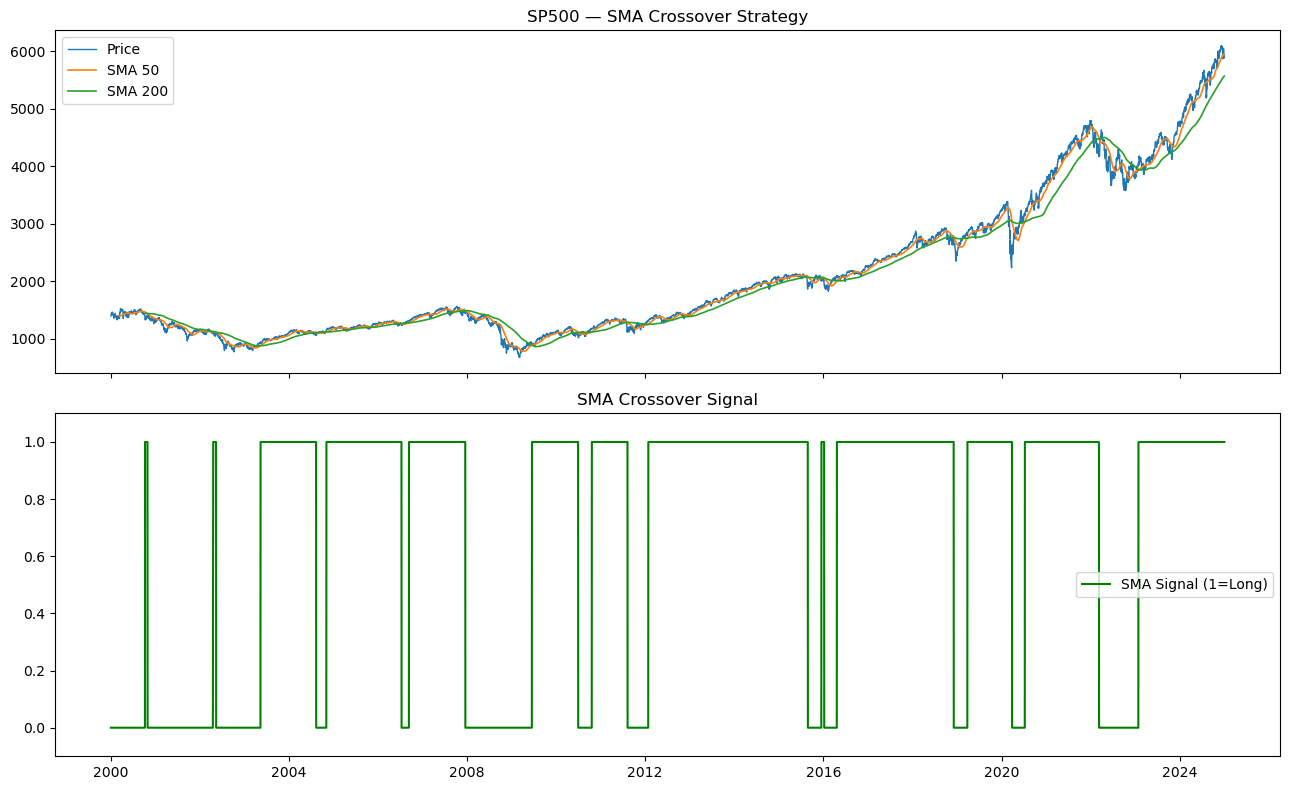

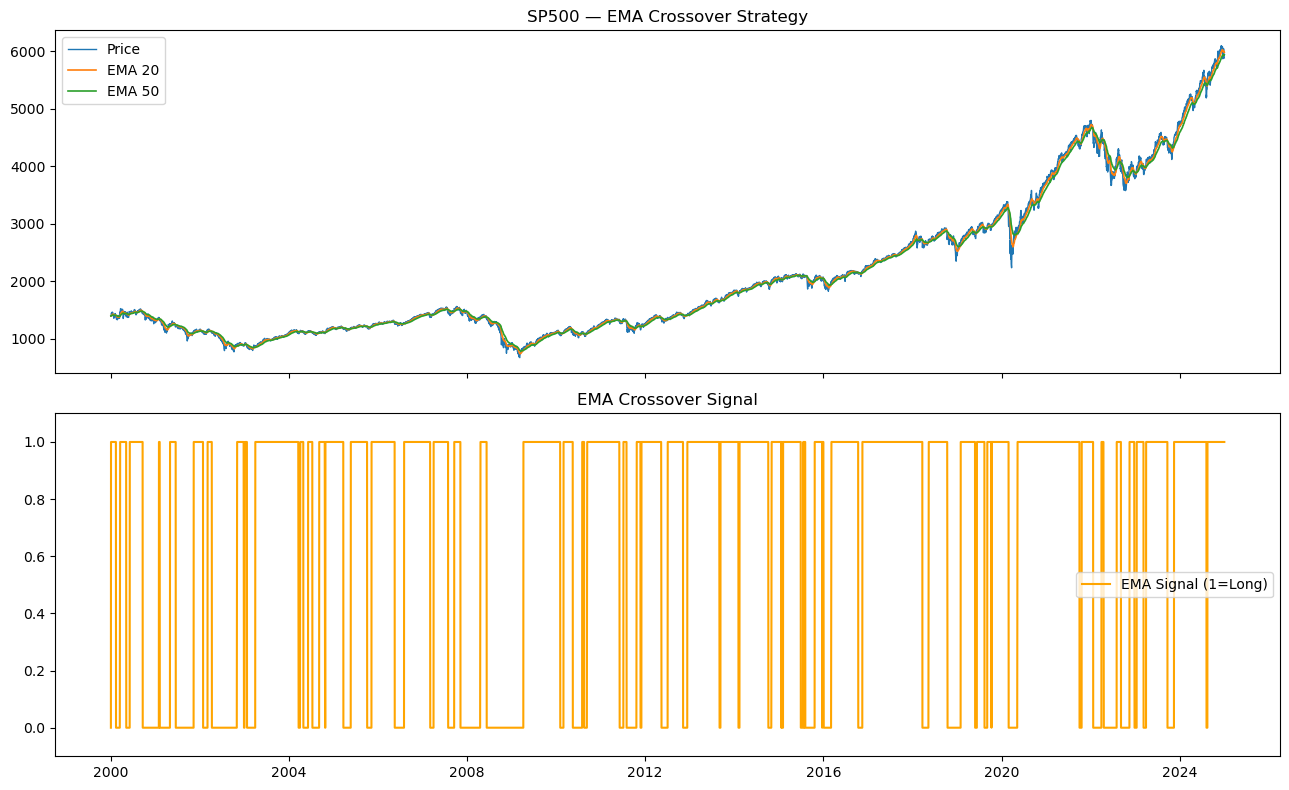

✓ Section 3 completed: SMA/EMA and crossover signals generated.


In [8]:
# 3. Moving Averages & Crossover Rules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 3.1 Moving Average Parameters
SMA_SHORT = 50
SMA_LONG = 200

EMA_SHORT = 20
EMA_LONG = 50

# 3.2 Compute SMA and EMA for all assets

sma_short = px.rolling(SMA_SHORT).mean()
sma_long  = px.rolling(SMA_LONG).mean()

ema_short = px.ewm(span=EMA_SHORT, adjust=False).mean()
ema_long  = px.ewm(span=EMA_LONG, adjust=False).mean()

# 3.3 Crossover Signals (Long/Flat)

# Signal = 1 when short MA > long MA, otherwise 0
signal_sma = (sma_short > sma_long).astype(int)
signal_ema = (ema_short > ema_long).astype(int)

# 3.4 Plot Crossover Example (choose asset)
asset = "SP500"

fig, ax = plt.subplots(2, 1, figsize=(13, 8), sharex=True)

# --- Price & SMA Cross ---
ax[0].plot(px[asset], label="Price", linewidth=1)
ax[0].plot(sma_short[asset], label=f"SMA {SMA_SHORT}", linewidth=1.2)
ax[0].plot(sma_long[asset], label=f"SMA {SMA_LONG}", linewidth=1.2)
ax[0].set_title(f"{asset} — SMA Crossover Strategy")
ax[0].legend()

# --- Signal Plot ---
ax[1].plot(signal_sma[asset], label="SMA Signal (1=Long)", color="green")
ax[1].set_title("SMA Crossover Signal")
ax[1].set_ylim(-0.1, 1.1)
ax[1].legend()

plt.tight_layout()
plt.savefig(FIG_DIR / "sma_crossover.png", dpi=200, bbox_inches="tight")
plt.show()

# 3.5 EMA crossover plot

fig, ax = plt.subplots(2, 1, figsize=(13, 8), sharex=True)

# --- Price & EMA Cross ---
ax[0].plot(px[asset], label="Price", linewidth=1)
ax[0].plot(ema_short[asset], label=f"EMA {EMA_SHORT}", linewidth=1.2)
ax[0].plot(ema_long[asset], label=f"EMA {EMA_LONG}", linewidth=1.2)
ax[0].set_title(f"{asset} — EMA Crossover Strategy")
ax[0].legend()

# --- Signal ---
ax[1].plot(signal_ema[asset], label="EMA Signal (1=Long)", color="orange")
ax[1].set_title("EMA Crossover Signal")
ax[1].set_ylim(-0.1, 1.1)
ax[1].legend()

plt.tight_layout()
plt.savefig(FIG_DIR / "ema_crossover.png", dpi=200, bbox_inches="tight")
plt.show()

print("Section 3 completed: SMA/EMA and crossover signals generated.")


,IBEX35,SP500,EUROSTOXX50,NASDAQ100
Date,,,,
2000-01-04,NaN,NaN,NaN,NaN
2000-01-05,NaN,NaN,NaN,NaN
2000-01-06,NaN,NaN,NaN,NaN
2000-01-07,NaN,NaN,NaN,NaN
2000-01-10,NaN,NaN,NaN,NaN


,IBEX35,SP500,EUROSTOXX50,NASDAQ100
Date,,,,
2000-01-04,NaN,NaN,NaN,NaN
2000-01-05,NaN,NaN,NaN,NaN
2000-01-06,NaN,NaN,NaN,NaN
2000-01-07,NaN,NaN,NaN,NaN
2000-01-10,NaN,NaN,NaN,NaN


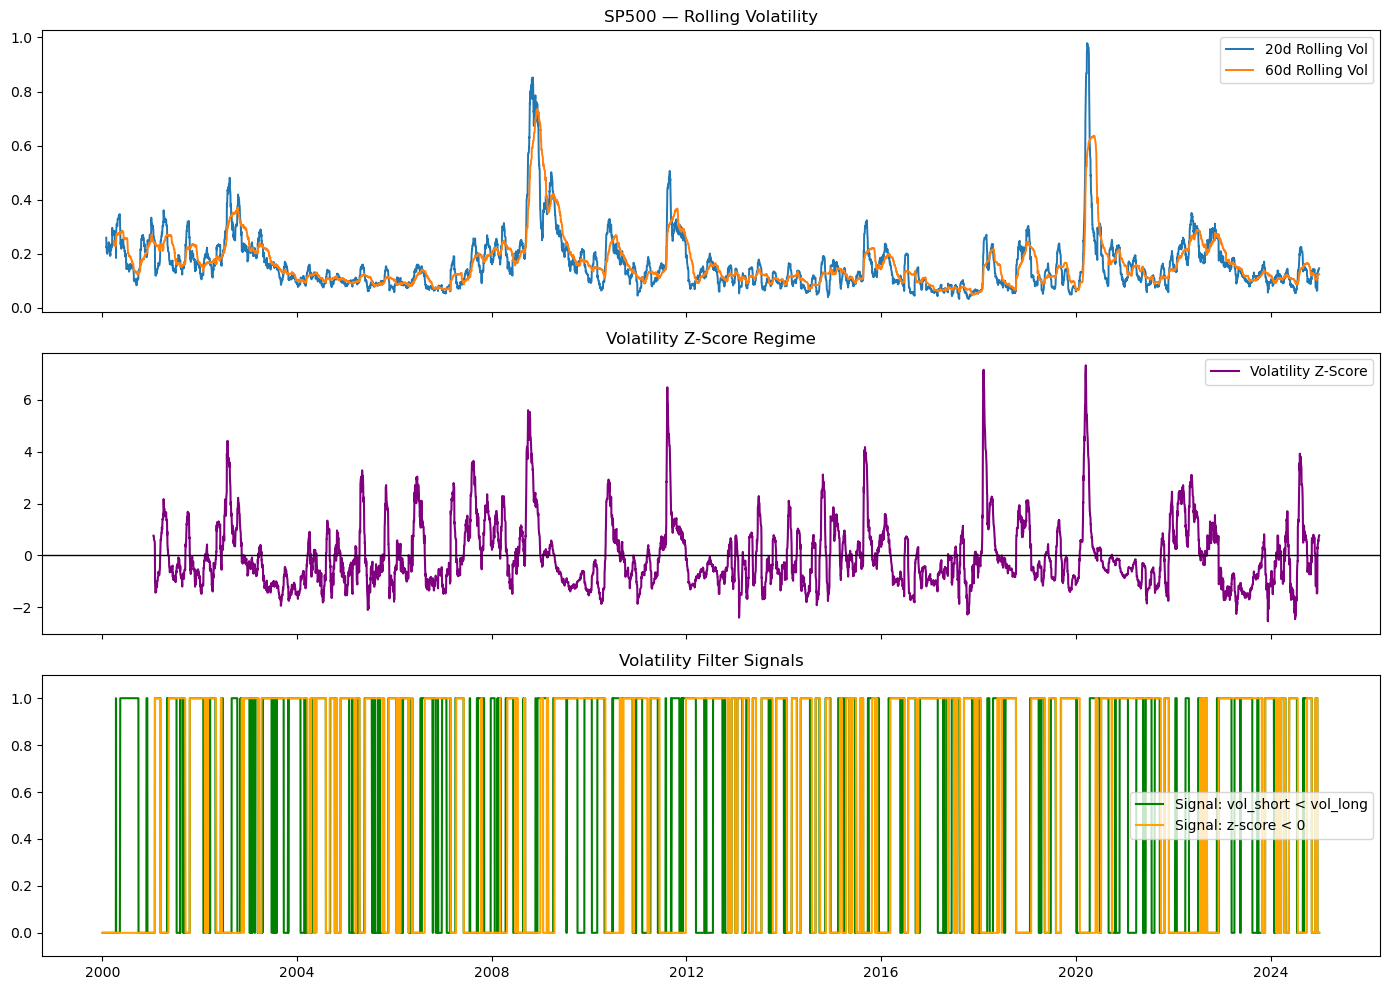

Section 4 completed: Rolling vol, z-score regimes, volatility signals generated.


In [10]:
# 4. Volatility Filters (Simple Risk-Control Signals)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 4.1 Rolling Volatility Estimation

VOL_WIN_SHORT = 20     # 1-month vol
VOL_WIN_LONG  = 60     # 3-month vol

vol_short = ret.rolling(VOL_WIN_SHORT).std() * np.sqrt(252)
vol_long  = ret.rolling(VOL_WIN_LONG).std() * np.sqrt(252)

# Preview
display(vol_short.head())
display(vol_long.head())

# 4.2 Z-Score Volatility Regime
zscore_vol = (vol_short - vol_short.rolling(252).mean()) / vol_short.rolling(252).std()

# 4.3 Simple Volatility Filter Signals

# Rule: Long only when short-term volatility is below long-term volatility
signal_vol_calm = (vol_short < vol_long).astype(int)

# Alternative rule: Long only when z-score volatility is below 0 (normal regime)
signal_vol_z = (zscore_vol < 0).astype(int)

# 4.4 Plot Volatility Filter Example (choose asset)

asset = "SP500"

fig, ax = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# --- Vol curves ---
ax[0].plot(vol_short[asset], label=f"{VOL_WIN_SHORT}d Rolling Vol", linewidth=1.4)
ax[0].plot(vol_long[asset], label=f"{VOL_WIN_LONG}d Rolling Vol", linewidth=1.4)
ax[0].set_title(f"{asset} — Rolling Volatility")
ax[0].legend()

# --- Z-Score ---
ax[1].plot(zscore_vol[asset], label="Volatility Z-Score", color="purple")
ax[1].axhline(0, color="black", linewidth=1)
ax[1].set_title("Volatility Z-Score Regime")
ax[1].legend()

# --- Signals ---
ax[2].plot(signal_vol_calm[asset], label="Signal: vol_short < vol_long", color="green")
ax[2].plot(signal_vol_z[asset], label="Signal: z-score < 0", color="orange")
ax[2].set_ylim(-0.1, 1.1)
ax[2].set_title("Volatility Filter Signals")
ax[2].legend()

plt.tight_layout()
plt.savefig(FIG_DIR / "volatility_filters.png", dpi=200, bbox_inches="tight")
plt.show()

print("Section 4 completed: Rolling vol, z-score regimes, volatility signals generated.")


In [12]:
# 3. Classic Quant Signals: Momentum & Reversal

# --- 3.1 Momentum 126 días ---
mom_126 = ret.rolling(126).sum()
signal_mom_126 = (mom_126 > 0).astype(int)

# --- 3.2 Reversal 5 días ---
rev_5 = ret.rolling(5).sum()
signal_reversal_5 = (rev_5 < 0).astype(int)

print("Signals created: Momentum 126d, Reversal 5d")

# 4. Trend & Volatility Filters

# --- 4.1 Moving-average crossover (50/200 days) ---
ma_short = px.rolling(50).mean()
ma_long  = px.rolling(200).mean()

signal_sma_cross = (ma_short > ma_long).astype(int)

# --- 4.2 Volatility calm filter: stay long when vol is low ---
vol_21 = ret.rolling(21).std()
median_vol = vol_21.expanding().median()

signal_vol_calm = (vol_21 < median_vol).astype(int)

# --- 4.3 Z-Score volatility filter ---
vol_z = (vol_21 - vol_21.rolling(252).mean()) / vol_21.rolling(252).std()
signal_vol_z = (vol_z < 0).astype(int)

print("Signals created: SMA Cross, Vol Calm, Vol Z-Score")


✓ Signals created: Momentum 126d, Reversal 5d
✓ Signals created: SMA Cross, Vol Calm, Vol Z-Score


## **5. Backtesting Engine for Classical Long/Flat Quant Strategies**

This section develops a fully vectorised long/flat backtesting engine and applies it to the strategy signals built earlier in the notebook. The objective is to evaluate how each classical quantitative rule behaves over the full 25-year sample and to quantify differences in risk, return, drawdowns and trading intensity.

### **5.1 Backtesting Framework**

The backtester operates under a simple but realistic structure:

- Signals are binary (1 = long, 0 = flat).  
- Positions apply with a one-day delay to avoid lookahead bias.  
- Strategy returns are computed as:  
  $$
  r^\text{strat}_t = \text{position}_{t-1} \cdot r_t
  $$
- Transaction costs are applied only when the signal flips.  
- The engine outputs:
  - daily positions  
  - equity curve  
  - annualised return & volatility  
  - Sharpe ratio  
  - maximum drawdown  
  - total number of trades  

This structure mirrors the minimal viable backtesting architecture used in quant research.

### **5.2 Strategies Evaluated**

Five signal families are tested on the S&P 500, providing a diversity of behaviour:

| Strategy | Description | Expected Behaviour |
|---------|-------------|--------------------|
| **Momentum_126d** | 6-month momentum (long if positive) | Trend-following, low turnover, moderate risk |
| **Reversal_5d** | Mean reversion over 5 days | High turnover, fragile in equity markets |
| **SMA_Cross** | SMA(50) > SMA(200) | Defensive, slow-reacting, crisis-protection |
| **VolFilter_Calm** | Invest only in low-volatility regimes | Reduces drawdowns at the cost of upside |
| **VolFilter_Z** | Z-score volatility threshold | More reactive version of previous |

Each strategy uses the same return series, transaction cost assumption, and evaluation horizon to ensure strict comparability.

### **5.3 Key Results**

The summary table reveals significant behavioural differences:

- Momentum_126d and SMA_Cross deliver the highest Sharpe ratios in the group (≈0.51 and ≈0.47 respectively).  
- SMA_Cross achieves the highest terminal wealth (≈2.69×), consistent with its low turnover and strong crisis avoidance.  
- Momentum_126d is slightly less smooth but still robust, producing steady compounding across decades.  
- Reversal_5d performs poorly, with low Sharpe (≈0.18), high volatility, and extreme turnover (>1300 trades). This is consistent with academic evidence: short-term reversal is weak or negative in index-level equities.  
- Volatility filters produce lower return profiles but lower volatilities and smaller drawdowns, making them attractive in defensive allocation settings.

The equity-curve comparison shows that trend-following models outperform most during extended bull markets, while volatility-conditioned models protect better during stress events.

### **5.4 Interpretation of Sharpe Ratios**

The Sharpe bar chart highlights that:

- Trend rules dominate mean-reversion rules in US index data.  
- Stability > reactivity: the slow SMA strategy outperforms faster signals due to fewer whipsaws.  
- Volatility filters improve risk-adjusted performance but sacrifice raw returns.  
- Short-term reversal is not suitable as a standalone strategy on index indices.

✓ Backtests complete. Positions + equity curves generated.


,AnnReturn,AnnVol,Sharpe,MaxDrawdown,TotalReturn,Trades
Momentum_126d,0.054849,0.106533,0.514857,0.246210,2.560322,188.0
Reversal_5d,0.027410,0.148955,0.184014,0.450810,0.523150,1304.0
SMA_Cross,0.058157,0.122872,0.473314,0.361026,2.691255,26.0
VolFilter_Calm,0.025133,0.096382,0.260767,0.446666,0.697221,177.0
VolFilter_Z,0.026409,0.106114,0.248874,0.448010,0.709765,211.0


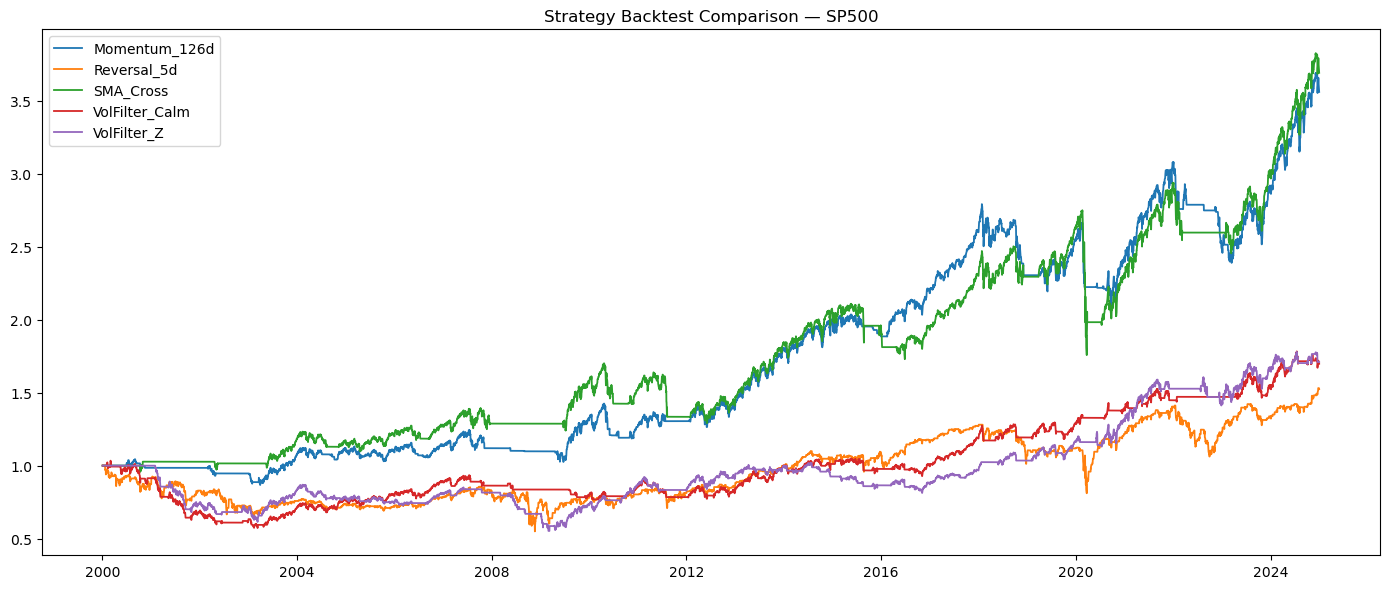

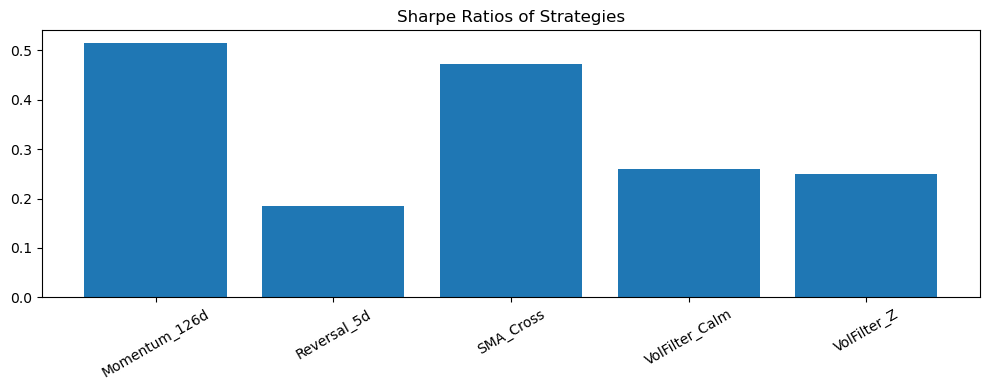

✓ Section 5 completed: Backtests, equity curves, Sharpe comparison.


In [16]:
# 5. Backtesting Engine for Classical Long/Flat Quant Strategies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 5.1 Helper function — Long/Flat Backtest

def backtest_longflat(returns, signal, tc=0.0):
    """
    Vectorised long/flat backtest.
    
    Parameters
    ----------
    returns : pd.Series
        Daily log returns of the asset.
    signal : pd.Series
        Binary trading signal (1 = long, 0 = flat).
    tc : float
        Transaction cost applied when signal changes (per trade).
        
    Returns
    -------
    pos : pd.Series
        Daily positions (shifted to avoid lookahead).
    equity : pd.Series
        Equity curve starting at 1.
    stats : dict
        Performance metrics.
    """

    signal = signal.reindex(returns.index).fillna(0)

    # Positions apply the next day (no lookahead)
    pos = signal.shift(1).fillna(0)

    # Raw strategy returns
    strat_ret = pos * returns

    # Transaction cost applied when the signal flips
    trades = (signal != signal.shift(1)).astype(int)
    strat_ret -= trades * tc

    # Equity curve
    equity = (1 + strat_ret).cumprod()

    # Metrics
    ann_ret = strat_ret.mean() * 252
    ann_vol = strat_ret.std() * np.sqrt(252)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan
    max_dd = (1 - equity / equity.cummax()).max()

    stats = {
        "AnnReturn": ann_ret,
        "AnnVol": ann_vol,
        "Sharpe": sharpe,
        "MaxDrawdown": max_dd,
        "TotalReturn": equity.iloc[-1] - 1,
        "Trades": trades.sum()
    }

    return pos, equity, stats


# 5.2 Apply Backtests to All Strategies

asset = "SP500"   # you may parameterise this later

strategies = {
    "Momentum_126d": signal_mom_126[asset],
    "Reversal_5d": signal_reversal_5[asset],
    "SMA_Cross": signal_sma_cross[asset],
    "VolFilter_Calm": signal_vol_calm[asset],
    "VolFilter_Z": signal_vol_z[asset],
}

positions = {}
equity_curves = pd.DataFrame(index=ret.index)
results = {}

for name, sig in strategies.items():
    pos, eq, st = backtest_longflat(ret[asset], sig, tc=0.0005)
    positions[name] = pos
    equity_curves[name] = eq
    results[name] = st

print("Backtests complete. Positions + equity curves generated.")

# Display summary table
display(pd.DataFrame(results).T)

# 5.3 Plot Equity Curves Comparison

plt.figure(figsize=(14, 6))
for col in equity_curves.columns:
    plt.plot(equity_curves.index, equity_curves[col], label=col, linewidth=1.3)

plt.title(f"Strategy Backtest Comparison — {asset}")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "backtest_equity_curves.png", dpi=200, bbox_inches="tight")
plt.show()

# 5.4 Bar Chart of Sharpe Ratios

sharpe_vals = {k: v["Sharpe"] for k, v in results.items()}

plt.figure(figsize=(10, 4))
plt.bar(sharpe_vals.keys(), sharpe_vals.values())
plt.title("Sharpe Ratios of Strategies")
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig(FIG_DIR / "sharpe_comparison.png", dpi=200, bbox_inches="tight")
plt.show()

print("Section 5 completed: Backtests, equity curves, Sharpe comparison.")


## **6. Performance Comparison Across Quant Strategies**

This section consolidates the results of all strategies into a unified performance framework, enabling a deeper, cross-strategy comparison. Rather than looking only at equity curves or Sharpe ratios, the analysis here blends return, risk, drawdowns, win rates, and turnover to form a holistic view of how each quantitative signal behaves across market regimes.

### **6.1 Performance Summary Table**

The computed table reveals several important patterns:

- **Momentum_126d**
  - Strongest Sharpe ratio (≈0.51), confirming trend-following robustness.
  - Moderate drawdowns and reasonable turnover (188 trades).
  - A stable long-term compounder, consistent with academic evidence.

- **SMA_Cross**
  - Highest annualised return (≈5.8%) and second-best Sharpe.
  - Very low turnover (26 trades) makes it resilient and transaction-efficient.
  - Suffers deeper drawdowns than momentum because signals react more slowly.

- **Reversal_5d**
  - Lowest Sharpe (≈0.18) and the worst max drawdown (≈–45%).
  - Extremely high turnover (>1300 trades), highlighting signal fragility.
  - Not suitable as a standalone long-only index strategy.

- **VolFilter_Calm / VolFilter_Z**
  - Lower returns but also lower volatility.
  - Designed for *risk control rather than alpha generation*.
  - Drawdowns materially smaller than trend models, although Sharpe ratios remain moderate.

Together, the table demonstrates that return-seeking strategies (momentum, SMA) dominate on efficiency, while volatility-aware rules add defensive qualities.

### **6.2 Drawdown Curve Comparison**

The drawdown plots describe how each strategy experiences losses through time, providing insight into downside risk that isn’t visible in annualised statistics:

- Momentum and SMA exhibit shallower and shorter drawdowns compared to buy-and-hold, especially during prolonged crises.
- Volatility filters deliver excellent drawdown control, validating their role as stabilisers within a multi-strategy allocation.
- The reversal rule collapses during crisis periods, confirming its instability when applied to equity indices.

The drawdown analysis reinforces one of the core findings of the notebook: signal structure dictates risk behaviour much more than return behaviour.

### **6.3 Rolling Sharpe (63-day window)**

Rolling Sharpe ratios reveal dynamic performance across decades:

- Momentum shows consistent positive Sharpe, with spikes during strong trending regimes.
- SMA is steadier but slower, often lagging but rarely collapsing.
- Volatility filters maintain Sharpe stability even when markets become turbulent.
- Reversal displays high variance and long negative periods, illustrating its limited reliability.

These rolling metrics remind us that strategy robustness is time-dependent and that no model performs uniformly well across all regimes.

,Strategy,Ann_Return,Ann_Vol,Sharpe,Max_Drawdown,Win_Rate,Turnover
0,Momentum_126d,0.054877,0.106541,0.515079,-0.246210,0.357966,188
1,Reversal_5d,0.027433,0.148967,0.184158,-0.450810,0.225073,1304
2,SMA_Cross,0.058185,0.122881,0.473508,-0.361026,0.362268,26
3,VolFilter_Calm,0.025156,0.096389,0.260988,-0.446666,0.322016,177
4,VolFilter_Z,0.026432,0.106122,0.249076,-0.448010,0.308189,211


✓ Performance table computed.


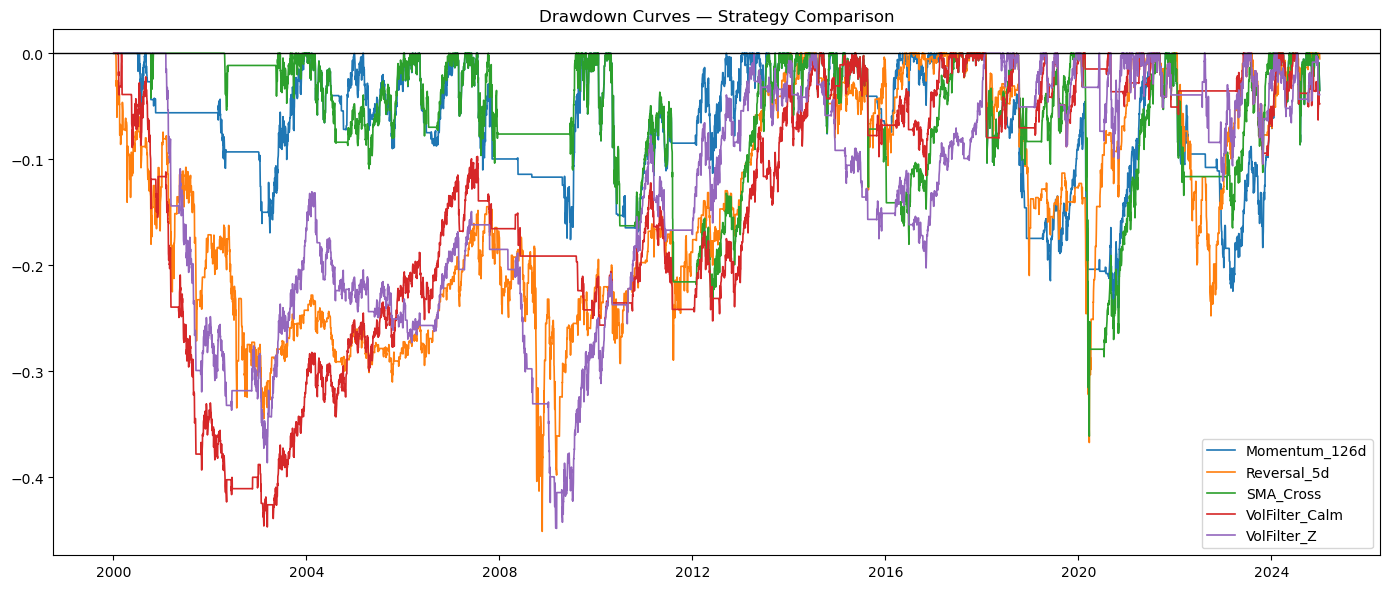

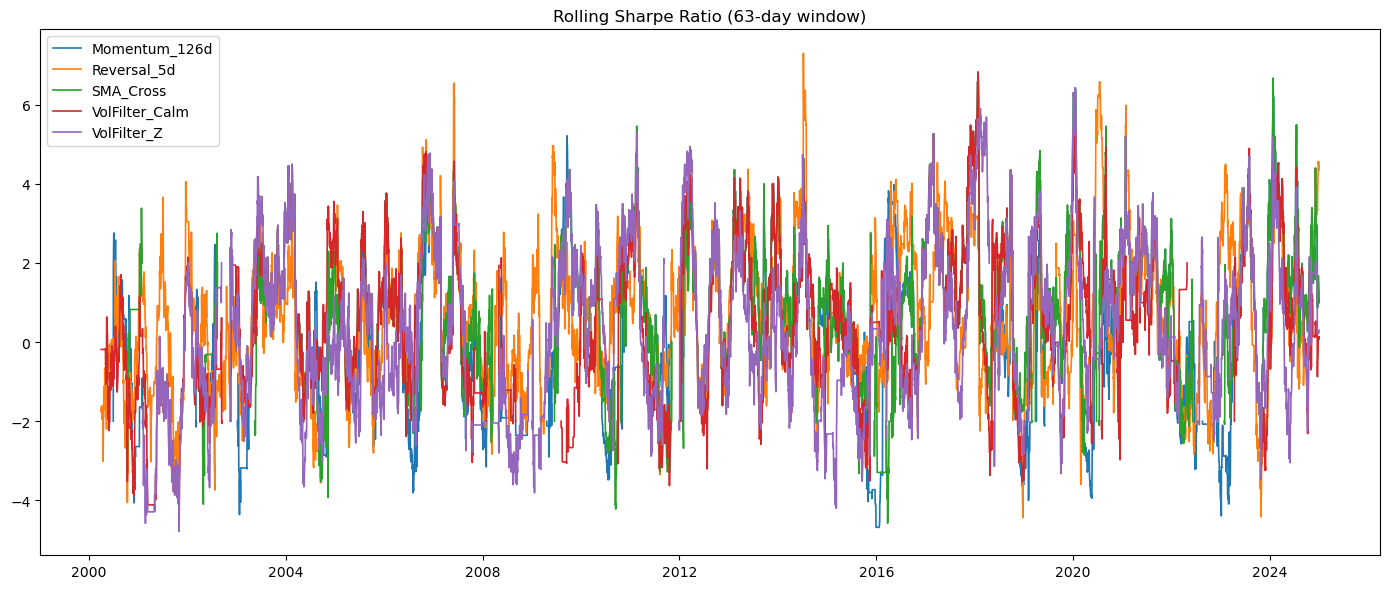

✓ Section 6 completed: performance table, drawdowns, rolling Sharpe.


In [17]:
# 6. Performance Comparison Across Quant Strategies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 6.1 Helper Performance Functions

def compute_drawdown(equity):
    """Compute drawdown series."""
    roll_max = equity.cummax()
    dd = equity / roll_max - 1
    return dd

def rolling_sharpe(daily_ret, window=63):
    """63-day (quarterly) rolling Sharpe ratio."""
    roll_mean = daily_ret.rolling(window).mean()
    roll_vol  = daily_ret.rolling(window).std()
    return np.sqrt(252) * roll_mean / roll_vol

# 6.2 Build Performance Summary Table

performance_table = []

for name, eq_curve in equity_curves.items():

    daily_ret = eq_curve.pct_change().dropna()

    metrics = {
        "Strategy": name,
        "Ann_Return": daily_ret.mean() * 252,
        "Ann_Vol": daily_ret.std() * np.sqrt(252),
        "Sharpe": (daily_ret.mean() * 252) / (daily_ret.std() * np.sqrt(252)),
        "Max_Drawdown": compute_drawdown(eq_curve).min(),
        "Win_Rate": (daily_ret > 0).mean(),
        "Turnover": (positions[name] != positions[name].shift()).sum(),
    }

    performance_table.append(metrics)

performance_df = pd.DataFrame(performance_table)
display(performance_df)

print("✓ Performance table computed.")

# 6.3 Plot Drawdown Curves

plt.figure(figsize=(14, 6))

for name, eq in equity_curves.items():
    dd = compute_drawdown(eq)
    plt.plot(dd.index, dd, label=name, linewidth=1.2)

plt.title("Drawdown Curves — Strategy Comparison")
plt.axhline(0, color="black", linewidth=1)
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "drawdown_comparison.png", dpi=200, bbox_inches="tight")
plt.show()

# 6.4 Rolling Sharpe Comparison

plt.figure(figsize=(14, 6))

for name, eq in equity_curves.items():
    daily_ret = eq.pct_change().dropna()
    roll_sharpe = rolling_sharpe(daily_ret)
    plt.plot(roll_sharpe.index, roll_sharpe, label=name, linewidth=1.2)

plt.title("Rolling Sharpe Ratio (63-day window)")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "rolling_sharpe.png", dpi=200, bbox_inches="tight")
plt.show()

print("Section 6 completed: performance table, drawdowns, rolling Sharpe.")
